# Benchmarking various methods for predicting properties of Organic Solar Cell materials

## Parses sTD-DFT and sTDA files

In [1]:
#!/usr/bin/env python
# coding: utf-8

from __future__ import print_function
import pandas as pd
import numpy as np
import glob
import scipy.constants as constants
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics


In [60]:
def parse_sTDDFT(filename, molecule, dictionary):
    '''
    Parses through sTD-DFT or sTDA output files. Comment out parameters that are not needed.

    Parameters
    -----------
    filename: str
        path to output file
    molecule: str
        name of molecule
    dictionary: dict
        dictionary name to add results to

    Returns
    -------
    dictionary[molecule]: list
        adds list of sTDDFT or sTDA descriptors to a dictionary for the molecule
    '''
    
    with open(filename, 'r', encoding = 'utf-8') as file:
        line = file.readline()
        oscs = []
        wavelength = []
        energyEV = []
        wavenumber = []
        while line:
            if 'ordered frontier orbitals' in line:
                for x in range(11):
                    line = file.readline()
                HOMOminus1 = float(line[9:15])
                line = file.readline()
                HOMO = float(line[9:15])
                line = file.readline()
                line = file.readline()
                LUMO = float(line[9:15])
                line = file.readline()
                LUMOplus1 = float(line[9:15])

                deltaHOMO = abs(HOMOminus1 - HOMO)
                deltaLUMO = abs(LUMO - LUMOplus1)

            elif 'ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS' in line:
                for x in range(5):
                    line = file.readline()
                opt_bg = float(line[6:15])                    
                while line != '\n':
                    oscs.append(float(line[25:37]))
                    wavelength.append(float(line[17:23]))
                    energyEV.append(float(line[6:15]) * 1.2398e-4)
                    wavenumber.append(float(line[6:15]))
                    line = file.readline()
                    
            elif 'FINAL SINGLE POINT ENERGY' in line:
                SinglePointEn = float(line[-22:-1])

            elif 'Magnitude (Debye)' in line:                    
                dipmom = float(line[-9:-1])
                
            elif 'TOTAL RUN TIME' in line:  
                split_line = line.split()
                hours = float(split_line[5])
                mins = float(split_line[7])
                seconds = float(split_line[9])
                
                total_mins = round((hours*60) + mins + (seconds/60), 3)

            line = file.readline()  
        line = file.readline()
   
    if len(oscs) != 0:

        #Finds the lowest energy strong oscillator strength (Osc >= 0.1) and its corresponding energy    
        for i in range(len(oscs)+1): 
            if i < len(oscs): 
                if oscs[i] >= 0.1:
                    index_of_oscs = i
                    break
                else:
                    continue
            else: #if the spectrum has no oscillation strengths greater than 0.1
                maxoscs = max(oscs) #finds the maximum osc. strength
                index_of_oscs = oscs.index(maxoscs)
        transition_energy = wavenumber[index_of_oscs] #transition energy in units of cm^-1 of of lowest energy transiton with largest osc. strength
        strongest_osc = oscs[index_of_oscs]  #lowest energy osillator strength greater than 0.1 (or max osc. strength is all less than 0.1)

        highest_oscs = 0.0
        opt_bg = round(energyEV[0], 2)
        
        # Opt bg is the energy of the first transition within the first 10 transition with an oscillator strength greater than 0.5 
        if len(oscs) < 12:
            for i in range(len(oscs)):
                if  oscs[i] > 0.5:
                    opt_bg = round(energyEV[i], 2)
                    break
        else:
            for x in range(12):
                if  oscs[x] > 0.5:
                    opt_bg = round(energyEV[x], 2)
                    break

        # max abs is the tallest peak within first 15 transitions            
        '''if len(oscs) < 15:
            for i in range(len(oscs)):
                if  oscs[i] > highest_oscs:
                    highest_oscs = oscs[i]
                    max_abs = wavelength[i]
        else:
            for x in range(15):
                if  oscs[x] > highest_oscs:
                    highest_oscs = oscs[x]
                    max_abs = wavelength[x] ''' 
                    
        # max abs is the tallest peak in the spectrum
        
        for x in range(len(oscs)):
            if  oscs[x] > highest_oscs:
                    highest_oscs = oscs[x]
                    max_abs = wavelength[x]
        
                    
        

        outputs = [HOMO, LUMO, opt_bg, max_abs, total_mins]

        #filename = filename.split('/')[-1].split('.',1)[0]

        dictionary[molecule] = outputs  

        return dictionary[molecule]

In [59]:
def parse_sTDA_xTB(filename, molecule, dictionary):
    '''
    Parses through sTD-DFT-xTB or sTDA-xTB output files. Comment out parameters that are not needed.

    Parameters
    -----------
    filename: str
        path to output file
    molecule: str
        name of molecule
    dictionary: dict
        dictionary name to add results to

    Returns
    -------
    dictionary[molecule]: list
        adds list of sTDDFT or sTDA descriptors to a dictionary for the molecule
    '''
    
    with open(filename, 'r', encoding = 'utf-8') as file:
        line = file.readline()
        oscs = []
        wavelength = []
        energyEV = []
        while line:
            if 'ordered frontier orbitals' in line:
                for x in range(11):
                    line = file.readline()
                line_list = line.split()
                HOMOminus1 = float(line_list[1])
                
                line = file.readline()
                line_list = line.split()
                HOMO = float(line_list[1])
                
                
                line = file.readline()
                line = file.readline()
                line_list = line.split()
                LUMO = float(line_list[1])
                line = file.readline()
                line_list = line.split()
                LUMOplus1 = float(line_list[1])

                deltaHOMO = abs(HOMOminus1 - HOMO)
                deltaLUMO = abs(LUMO - LUMOplus1)

            elif 'excitation energies, transition moments and TDA amplitudes' in line:
                line = file.readline()
                line = file.readline()
                line_list = line.split()
                opt_bg = float(line_list[1])                   
                while line != '\n':
                    line_list = line.split()
                    oscs.append(float(line_list[3]))
                    wavelength.append(float(line_list[2]))
                    energyEV.append(float(line_list[1]))
                    line = file.readline()

            line = file.readline()  
        line = file.readline()
   
    if len(oscs) != 0:

      #Finds the lowest energy strong oscillator strength (Osc >= 0.1) and its corresponding energy    
        '''for i in range(len(oscs)+1): 
            if i < len(oscs): 
                if oscs[i] >= 0.1:
                    index_of_oscs = i
                    break
                else:
                    continue
            else: #if the spectrum has no oscillation strengths greater than 0.1
                maxoscs = max(oscs) #finds the maximum osc. strength
                index_of_oscs = oscs.index(maxoscs)
        strongest_osc = oscs[index_of_oscs]  #lowest energy osillator strength greater than 0.1 (or max osc. strength is all less than 0.1)

        highest_oscs = 0.0
        first_oscs = oscs[0]
        opt_bg = round(energyEV[0], 2)
        
        if len(oscs) < 3:
            for i in range(len(oscs)):
                if  oscs[i] > highest_oscs:
                    highest_oscs = oscs[i]
                    lowestenergytransitioneV= energyEV[i]

        else:
            for x in range(5):
                if  oscs[x] > highest_oscs:
                    highest_oscs = oscs[x]
                    lowestenergytransitioneV= energyEV[x]
                    max_abs = wavelength[x]
        #summed_oscs = np.sum(oscs)'''
        
        
        highest_oscs = 0.0
        opt_bg = round(energyEV[0], 2)
        
        # Opt bg is the energy of the first transition within the first 10 transition with an oscillator strength greater than 0.5 
        if len(oscs) < 12:
            for i in range(len(oscs)):
                if  oscs[i] > 0.5:
                    opt_bg = round(energyEV[i], 2)
                    break
        else:
            for x in range(12):
                if  oscs[x] > 0.5:
                    opt_bg = round(energyEV[x], 2)
                    break

        # max abs is the tallest peak within first 15 transitions            
        '''if len(oscs) < 15:
            for i in range(len(oscs)):
                if  oscs[i] > highest_oscs:
                    highest_oscs = oscs[i]
                    max_abs = wavelength[i]
        else:
            for x in range(15):
                if  oscs[x] > highest_oscs:
                    highest_oscs = oscs[x]
                    max_abs = wavelength[x]'''

                    
        # max abs is the tallest peak in the spectrum
        for x in range(len(oscs)):
            if  oscs[x] > highest_oscs:
                    highest_oscs = oscs[x]
                    max_abs = wavelength[x]
        
        outputs = [HOMO, LUMO, opt_bg, max_abs]

        #filename = filename.split('/')[-1].split('.',1)[0]

        dictionary[molecule] = outputs  

        return dictionary[molecule]

In [4]:
def parse_GFN2(filename, molecule, dictionary):
    '''
    Parses through GFN2-xTB output files. Comment out parameters that are not needed.

    Parameters
    -----------
    filename: str
        path to output file
    molecule: str
        name of molecule
    dictionary: dict
        dictionary name to add results to

    Returns
    -------
    dictionary[molecule]: list
        adds list of sTDDFT or sTDA descriptors to a dictionary for the molecule
    '''
    
    with open(filename, 'r', encoding = 'utf-8') as file:
        line = file.readline()
        while line:
            if 'Orbital Energies and Occupations' in line:
                while 'HOMO' not in line:
                    line = file.readline()
                    
                line_list = line.split()
                HOMO = float(line_list[3])
                
                line = file.readline()
                line_list = line.split()
                if len(line_list) == 4:
                    LUMO = float(line_list[2])
                else:
                    LUMO = float(line_list[3])

            line = file.readline()  
        line = file.readline()
   

        outputs = [HOMO, LUMO]

        #filename = filename.split('/')[-1].split('.',1)[0]

        dictionary[molecule] = outputs  

        return dictionary[molecule]
    
def parse_xtb_vipea(filename, molecule, dictionary):
    '''
    Parses through GFN2-xTB -vipea output files.

    Parameters
    -----------
    filename: str
        path to output file
    molecule: str
        name of molecule
    dictionary: dict
        dictionary name to add results to

    Returns
    -------
    dictionary[molecule]: list
        adds list of sTDDFT or sTDA descriptors to a dictionary for the molecule
    '''
    
    with open(filename, 'r', encoding = 'utf-8') as file:
        line = file.readline()
        while line:
            if 'convergence criteria cannot be satisfied within 250 iterations' in line:
                print(molecule)
                return molecule
            elif 'delta SCC IP (eV)' in line:

                line_list = line.split()
                HOMO = float(line_list[-1]) * -1
                
            elif 'delta SCC EA (eV)' in line:
                line_list = line.split()
                LUMO = float(line_list[-1]) * -1               

            line = file.readline()  
        line = file.readline()
   

        outputs = [HOMO, LUMO]

        #filename = filename.split('/')[-1].split('.',1)[0]

        dictionary[molecule] = outputs  

        return dictionary[molecule]

In [49]:
exp_data  = pd.read_csv("../molecule_exp_data.csv", index_col="Molecule")

exp_data = exp_data.dropna(how='all')
exp_data


,AorD,HOMO,LUMO,optbg,wavelength_film,wavelength_soln
Molecule,,,,,,
2D-PBTCl,D,-5.45,-3.60,1.72,627.0,625.0
2D-PBTCl2,D,-5.43,-3.63,1.66,642.0,593.0
2FIFIC,A,-5.45,-3.97,1.38,817.0,750.0
2T2Se-F,A,-5.52,-3.83,1.31,806.0,694.0
2TC-TT-BDTFT,D,-5.45,-3.50,NaN,NaN,NaN
...,...,...,...,...,...,...
ZITI,A,-5.56,-3.77,1.53,747.0,712.0
ZITI-C,A,-5.65,-3.81,NaN,NaN,NaN
ZITI-N,A,-5.57,-3.82,NaN,NaN,NaN


In [50]:
sTDDFT_outputs = {}


for file in glob.iglob('../Calculations/acceptors/wb97x-d3_sTDDFT/*.out'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_sTDDFT(file, filename, sTDDFT_outputs)

for file in glob.iglob('../Calculations/donors/wb97xd-3_sTDDFT_output/*.out'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_sTDDFT(file, filename, sTDDFT_outputs)

df_sTDDFT = pd.DataFrame.from_dict(sTDDFT_outputs, orient='index', columns = ['sTDDFT_HOMO', 'sTDDFT_LUMO', 'sTDDFT_optbg', 'sTDDFT_max_abs', 'sTDDFT_total_mins'])
df_sTDDFT

,sTDDFT_HOMO,sTDDFT_LUMO,sTDDFT_optbg,sTDDFT_max_abs,sTDDFT_total_mins
2FIFIC,-7.32,-2.23,2.20,562.6,12.533
2T2Se-F,-7.47,-2.29,2.20,564.8,8.350
3TT-OCIC,-7.33,-2.33,2.05,605.7,23.033
4T-1,-7.44,-2.09,2.44,508.9,10.483
4TC-4F-C8C8,-7.26,-2.03,2.44,507.2,22.933
...,...,...,...,...,...
PvBDT-F,-6.85,-0.94,2.94,421.4,42.333
Qx-10F,-6.69,-1.26,2.61,474.2,68.650
Qx-12F,-6.76,-1.45,2.48,500.0,72.117
Qx-8F,-6.59,-1.24,2.47,502.9,70.317


In [51]:
df3 = pd.concat([exp_data, df_sTDDFT], axis=1)
#df3 = df3.dropna()
df3


,AorD,HOMO,LUMO,optbg,wavelength_film,wavelength_soln,sTDDFT_HOMO,sTDDFT_LUMO,sTDDFT_optbg,sTDDFT_max_abs,sTDDFT_total_mins
2D-PBTCl,D,-5.45,-3.60,1.72,627.0,625.0,-6.71,-1.30,2.61,474.1,36.217
2D-PBTCl2,D,-5.43,-3.63,1.66,642.0,593.0,NaN,NaN,NaN,NaN,NaN
2FIFIC,A,-5.45,-3.97,1.38,817.0,750.0,-7.32,-2.23,2.20,562.6,12.533
2T2Se-F,A,-5.52,-3.83,1.31,806.0,694.0,-7.47,-2.29,2.20,564.8,8.350
2TC-TT-BDTFT,D,-5.45,-3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
ZITI,A,-5.56,-3.77,1.53,747.0,712.0,-7.20,-1.96,2.38,305.1,10.600
ZITI-C,A,-5.65,-3.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZITI-N,A,-5.57,-3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZITI-S,A,-5.80,-3.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
sTDA_outputs = {}

for file in glob.iglob('../Calculations/acceptors/wb97x-d3_sTDA/*.out'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_sTDDFT(file, filename, sTDA_outputs)
    
for file in glob.iglob('../Calculations/donors/wb97x-d3_sTDA/*.out'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_sTDDFT(file, filename, sTDA_outputs)
    
df_sTDA = pd.DataFrame.from_dict(sTDA_outputs, orient='index', columns = ['sTDA_HOMO', 'sTDA_LUMO', 'sTDA_optbg', 'sTDA_max_abs', 'sTDA_total_mins'])
df_sTDA

,sTDA_HOMO,sTDA_LUMO,sTDA_optbg,sTDA_max_abs,sTDA_total_mins
2FIFIC,-7.32,-2.23,2.25,552.2,17.367
2T2Se-F,-7.47,-2.29,2.22,558.1,8.483
3TT-OCIC,-7.33,-2.33,2.07,597.5,23.133
4T-1,-7.44,-2.09,2.47,502.9,8.517
4TC-4F-C8C8,-7.26,-2.03,2.47,502.1,22.400
...,...,...,...,...,...
PvBDT-F,-6.85,-0.94,2.95,420.5,42.367
Qx-10F,-6.69,-1.26,2.63,471.8,72.367
Qx-12F,-6.76,-1.45,2.50,496.7,72.283
Qx-8F,-6.59,-1.24,2.48,499.2,70.017


In [53]:
df4 = pd.concat([df3, df_sTDA], axis=1)
df4

,AorD,HOMO,LUMO,optbg,wavelength_film,wavelength_soln,sTDDFT_HOMO,sTDDFT_LUMO,sTDDFT_optbg,sTDDFT_max_abs,sTDDFT_total_mins,sTDA_HOMO,sTDA_LUMO,sTDA_optbg,sTDA_max_abs,sTDA_total_mins
2D-PBTCl,D,-5.45,-3.60,1.72,627.0,625.0,-6.71,-1.30,2.61,474.1,36.217,-6.71,-1.30,2.63,471.1,38.217
2D-PBTCl2,D,-5.43,-3.63,1.66,642.0,593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2FIFIC,A,-5.45,-3.97,1.38,817.0,750.0,-7.32,-2.23,2.20,562.6,12.533,-7.32,-2.23,2.25,552.2,17.367
2T2Se-F,A,-5.52,-3.83,1.31,806.0,694.0,-7.47,-2.29,2.20,564.8,8.350,-7.47,-2.29,2.22,558.1,8.483
2TC-TT-BDTFT,D,-5.45,-3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZITI,A,-5.56,-3.77,1.53,747.0,712.0,-7.20,-1.96,2.38,305.1,10.600,-7.20,-1.96,2.41,302.2,10.567
ZITI-C,A,-5.65,-3.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZITI-N,A,-5.57,-3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZITI-S,A,-5.80,-3.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
sTDA_xTB = {}

for file in glob.iglob('../Calculations/acceptors/sTDA-xTB/*.stda'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_sTDA_xTB(file, filename, sTDA_xTB)
    
for file in glob.iglob('../Calculations/donors/sTDA-xTB/*.stda'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_sTDA_xTB(file, filename, sTDA_xTB)
    
df_sTDA_xTB = pd.DataFrame.from_dict(sTDA_xTB, orient='index', columns = ['sTDA-xTB_HOMO', 'sTDA-xTB_LUMO', 'sTDA-xTB_optbg', 'sTDA-xTB_max_abs'])
df_sTDA_xTB



,sTDA-xTB_HOMO,sTDA-xTB_LUMO,sTDA-xTB_optbg,sTDA-xTB_max_abs
2FIFIC,-13.838,-9.186,2.46,504.8
2T2Se-F,-14.009,-9.318,2.37,523.4
3TT-OCIC,-13.668,-9.156,2.31,536.1
4T-1,-13.948,-9.195,2.51,494.8
4TC-4F-C8C8,-13.928,-9.125,2.46,398.3
...,...,...,...,...
PvBDT-F,-13.343,-7.944,3.17,391.1
Qx-10F,-13.343,-7.944,3.17,391.1
Qx-12F,-13.343,-7.944,3.17,391.1
Qx-8F,-13.343,-7.944,3.17,391.1


In [62]:
df5 = pd.concat([df4, df_sTDA_xTB], axis=1)
df5

,AorD,HOMO,LUMO,optbg,wavelength_film,wavelength_soln,sTDDFT_HOMO,sTDDFT_LUMO,sTDDFT_optbg,sTDDFT_max_abs,sTDDFT_total_mins,sTDA_HOMO,sTDA_LUMO,sTDA_optbg,sTDA_max_abs,sTDA_total_mins,sTDA-xTB_HOMO,sTDA-xTB_LUMO,sTDA-xTB_optbg,sTDA-xTB_max_abs
2D-PBTCl,D,-5.45,-3.60,1.72,627.0,625.0,-6.71,-1.30,2.61,474.1,36.217,-6.71,-1.30,2.63,471.1,38.217,-13.118,-8.106,2.79,445.0
2D-PBTCl2,D,-5.43,-3.63,1.66,642.0,593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2FIFIC,A,-5.45,-3.97,1.38,817.0,750.0,-7.32,-2.23,2.20,562.6,12.533,-7.32,-2.23,2.25,552.2,17.367,-13.838,-9.186,2.46,504.8
2T2Se-F,A,-5.52,-3.83,1.31,806.0,694.0,-7.47,-2.29,2.20,564.8,8.350,-7.47,-2.29,2.22,558.1,8.483,-14.009,-9.318,2.37,523.4
2TC-TT-BDTFT,D,-5.45,-3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZITI,A,-5.56,-3.77,1.53,747.0,712.0,-7.20,-1.96,2.38,305.1,10.600,-7.20,-1.96,2.41,302.2,10.567,-14.090,-9.122,2.56,484.6
ZITI-C,A,-5.65,-3.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZITI-N,A,-5.57,-3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZITI-S,A,-5.80,-3.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
sTDDFT_xTB = {}

for file in glob.iglob('../Calculations/acceptors/sTDDFT-xTB/*.stda'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_sTDA_xTB(file, filename, sTDDFT_xTB)
    
for file in glob.iglob('../Calculations/donors/sTDDFT-xTB/*.stda'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_sTDA_xTB(file, filename, sTDDFT_xTB)
    
df_sTDDFT_xTB = pd.DataFrame.from_dict(sTDDFT_xTB, orient='index', columns = ['sTDDFT-xTB_HOMO', 'sTDDFT-xTB_LUMO', 'sTDDFT-xTB_optbg', 'sTDDFT-xTB_max_abs'])
df_sTDDFT_xTB


,sTDDFT-xTB_HOMO,sTDDFT-xTB_LUMO,sTDDFT-xTB_optbg,sTDDFT-xTB_max_abs
2FIFIC,-13.838,-9.186,2.39,518.3
2T2Se-F,-14.009,-9.318,2.32,533.9
3TT-OCIC,-13.668,-9.156,2.27,545.4
4T-1,-13.948,-9.195,2.46,504.3
4TC-4F-C8C8,-13.928,-9.125,2.41,444.0
...,...,...,...,...
PvBDT-F,-13.343,-7.944,3.16,391.9
Qx-10F,-13.343,-7.944,3.16,391.9
Qx-12F,-13.343,-7.944,3.16,391.9
Qx-8F,-13.343,-7.944,3.16,391.9


In [64]:
df6 = pd.concat([df5, df_sTDDFT_xTB], axis=1)
df6

,AorD,HOMO,LUMO,optbg,wavelength_film,wavelength_soln,sTDDFT_HOMO,sTDDFT_LUMO,sTDDFT_optbg,sTDDFT_max_abs,...,sTDA_max_abs,sTDA_total_mins,sTDA-xTB_HOMO,sTDA-xTB_LUMO,sTDA-xTB_optbg,sTDA-xTB_max_abs,sTDDFT-xTB_HOMO,sTDDFT-xTB_LUMO,sTDDFT-xTB_optbg,sTDDFT-xTB_max_abs
2D-PBTCl,D,-5.45,-3.60,1.72,627.0,625.0,-6.71,-1.30,2.61,474.1,...,471.1,38.217,-13.118,-8.106,2.79,445.0,-13.118,-8.106,2.76,449.8
2D-PBTCl2,D,-5.43,-3.63,1.66,642.0,593.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2FIFIC,A,-5.45,-3.97,1.38,817.0,750.0,-7.32,-2.23,2.20,562.6,...,552.2,17.367,-13.838,-9.186,2.46,504.8,-13.838,-9.186,2.39,518.3
2T2Se-F,A,-5.52,-3.83,1.31,806.0,694.0,-7.47,-2.29,2.20,564.8,...,558.1,8.483,-14.009,-9.318,2.37,523.4,-14.009,-9.318,2.32,533.9
2TC-TT-BDTFT,D,-5.45,-3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZITI,A,-5.56,-3.77,1.53,747.0,712.0,-7.20,-1.96,2.38,305.1,...,302.2,10.567,-14.090,-9.122,2.56,484.6,-14.090,-9.122,2.52,492.4
ZITI-C,A,-5.65,-3.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZITI-N,A,-5.57,-3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZITI-S,A,-5.80,-3.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
GFN2 = {}

for file in glob.iglob('../Calculations/acceptors/GFN2_output/*.out'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_GFN2(file, filename, GFN2)
    
for file in glob.iglob('../Calculations/donors/GFN2_output/*.out'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_GFN2(file, filename, GFN2)
    
df_GFN2 = pd.DataFrame.from_dict(GFN2, orient='index', columns = ['GFN2_HOMO', 'GFN2_LUMO'])
df_GFN2

,GFN2_HOMO,GFN2_LUMO
2FIFIC,-10.3109,-9.3307
2T2Se-F,-10.4507,-9.4929
3TT-OCIC,-10.1792,-9.2957
4T-1,-10.3137,-9.3832
4TC-4F-C8C8,-9.9081,-9.2929
...,...,...
T-EHPPD-T-EHBDT,-9.6872,-9.0563
TPD-3F,-9.8577,-8.6627
TTFQx-T1,-9.5921,-8.7220
W1,-9.7729,-8.3505


In [66]:
df7 = pd.concat([df6, df_GFN2], axis=1)
df7

,AorD,HOMO,LUMO,optbg,wavelength_film,wavelength_soln,sTDDFT_HOMO,sTDDFT_LUMO,sTDDFT_optbg,sTDDFT_max_abs,...,sTDA-xTB_HOMO,sTDA-xTB_LUMO,sTDA-xTB_optbg,sTDA-xTB_max_abs,sTDDFT-xTB_HOMO,sTDDFT-xTB_LUMO,sTDDFT-xTB_optbg,sTDDFT-xTB_max_abs,GFN2_HOMO,GFN2_LUMO
2D-PBTCl,D,-5.45,-3.60,1.72,627.0,625.0,-6.71,-1.30,2.61,474.1,...,-13.118,-8.106,2.79,445.0,-13.118,-8.106,2.76,449.8,-9.6517,-8.5673
2D-PBTCl2,D,-5.43,-3.63,1.66,642.0,593.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.6402,-8.6388
2FIFIC,A,-5.45,-3.97,1.38,817.0,750.0,-7.32,-2.23,2.20,562.6,...,-13.838,-9.186,2.46,504.8,-13.838,-9.186,2.39,518.3,-10.3109,-9.3307
2T2Se-F,A,-5.52,-3.83,1.31,806.0,694.0,-7.47,-2.29,2.20,564.8,...,-14.009,-9.318,2.37,523.4,-14.009,-9.318,2.32,533.9,-10.4507,-9.4929
2TC-TT-BDTFT,D,-5.45,-3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p_chen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.7553,-8.8931
P_suman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.4796,-8.4506
P_T4-DPP-M_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.4859,-8.6644
P_T4-iI-M_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.5174,-8.5894


In [67]:
xtb_vipea = {}

for file in glob.iglob('../Calculations/acceptors/GFN2_vipea/*.out'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_xtb_vipea(file, filename, xtb_vipea)
    
for file in glob.iglob('../Calculations/donors/xtb_vipea/*.out'):
    filename = file.split('\\')[-1].split('.')[0]
    parse_xtb_vipea(file, filename, xtb_vipea)
    
df_vipea = pd.DataFrame.from_dict(xtb_vipea, orient='index', columns = ['xtb_vipea_HOMO', 'xtb_vipea_LUMO'])
df_vipea

,xtb_vipea_HOMO,xtb_vipea_LUMO
2FIFIC,-4.9427,-2.7631
2T2Se-F,-5.6128,-2.5634
3TT-OCIC,-5.0304,-3.0340
4T-1,-5.2385,-3.0128
4TC-4F-C8C8,-4.0074,-2.2625
...,...,...
PvBDT-F,-5.3495,-2.5330
Qx-10F,-3.5188,-2.2549
Qx-12F,-3.3775,-2.1915
Qx-8F,-3.5589,-2.2636


In [68]:
df8 = pd.concat([df7, df_vipea], axis=1)
df8.tail(10)

,AorD,HOMO,LUMO,optbg,wavelength_film,wavelength_soln,sTDDFT_HOMO,sTDDFT_LUMO,sTDDFT_optbg,sTDDFT_max_abs,...,sTDA-xTB_optbg,sTDA-xTB_max_abs,sTDDFT-xTB_HOMO,sTDDFT-xTB_LUMO,sTDDFT-xTB_optbg,sTDDFT-xTB_max_abs,GFN2_HOMO,GFN2_LUMO,xtb_vipea_HOMO,xtb_vipea_LUMO
PE4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.6745,-8.5228,NaN,NaN
PfBTAZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.5132,-8.6841,NaN,NaN
PfBTAZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.5110,-8.6800,NaN,NaN
PhI-ffBT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.7356,-8.8387,NaN,NaN
PTQ2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.7398,-8.5468,NaN,NaN
p_chen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.7553,-8.8931,NaN,NaN
P_suman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.4796,-8.4506,NaN,NaN
P_T4-DPP-M_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.4859,-8.6644,NaN,NaN
P_T4-iI-M_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.5174,-8.5894,NaN,NaN
P_T4-TPD-M_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.6374,-8.4531,NaN,NaN


In [70]:
df8.to_csv('benchmarking.csv')  

# Plot time difference for each method for 6 cores

In [19]:
print(df8['sTDDFT_total_mins'].mean())
print(df8['sTDA_total_mins'].mean())

25.508788944723644
25.764944723618104


sTDA takes a bit longer than sTD-DFT

# Plotting correlation between experimental and computed

In [20]:
def linear_regression(x, y):     
    N = len(x)
    x_mean = x.mean()
    y_mean = y.mean()
    
    B1_num = ((x - x_mean) * (y - y_mean)).sum()
    B1_den = ((x - x_mean)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean - (B1*x_mean)
    
    reg_line = 'y = {} x + {}'.format(str(round(B1, 3)), str(round(B0, 3)))
    
    return (B0, B1, reg_line)

def corr_coef(x, y):
    N = len(x)
    
    num = (N * (x*y).sum()) - (x.sum() * y.sum())
    den = np.sqrt((N * (x**2).sum() - x.sum()**2) * (N * (y**2).sum() - y.sum()**2))
    R = num / den
    return R

In [21]:
def plot_correlation(predicted, target, x_text, y_text, x_axis_label, y_axis_label, savefig_name):
    fig, ax = plt.subplots(figsize = (5.5, 5))
    ax.scatter(predicted, target, color = '#332288')
    # adds line of best fit
    m, b = np.polyfit(predicted, target, 1)
    ax.plot(predicted, m*predicted + b, color='gold', linewidth=5)

    ax.set_ylabel(y_axis_label, labelpad=10, weight='bold', size=16)
    ax.set_xlabel(x_axis_label, labelpad=10, weight='bold', size=16)
    ax.tick_params(axis = 'x', labelsize=14)
    ax.tick_params(axis = 'y', labelsize=14)

    RMSE = metrics.mean_squared_error(target, predicted, squared=False )
    B0, B1, reg_line = linear_regression(predicted, target)
    R = corr_coef(predicted, target)
    ax.text(x_text, y_text, reg_line + '\n$R^2$=' + str(round(R**2, 3)) +'\nRMSE=' + str(round(RMSE, 3)), ha='left', size=12)
    plt.tight_layout()
    
    plt.savefig(savefig_name+'.pdf', dpi=600)
    plt.savefig(savefig_name+'.png', dpi=600)
    plt.show()

## Removing some molecules with incorret geometries until they are fixed

In [71]:
df8 = df8.drop('M1')
df8 = df8.drop('S-WSeSe-Cl')
df8 = df8.drop('TTPTTT-IC')
df8 = df8.drop('Y19')
df8 = df8.drop('Y5')
df8 = df8.drop('Y6')
df8 = df8.drop('3TT-OCIC')
df8 = df8.drop('AOIC1')
df8 = df8.drop('BTP-ClBr1')
df8 = df8.drop('BTP-N')
df8 = df8.drop('PBB-F')
df8 = df8.drop('PBDT-DTN')
df8 = df8.drop('PDBT-2F')
df8 = df8.drop('PDBT-Cl')
df8

,AorD,HOMO,LUMO,optbg,wavelength_film,wavelength_soln,sTDDFT_HOMO,sTDDFT_LUMO,sTDDFT_optbg,sTDDFT_max_abs,...,sTDA-xTB_optbg,sTDA-xTB_max_abs,sTDDFT-xTB_HOMO,sTDDFT-xTB_LUMO,sTDDFT-xTB_optbg,sTDDFT-xTB_max_abs,GFN2_HOMO,GFN2_LUMO,xtb_vipea_HOMO,xtb_vipea_LUMO
2D-PBTCl,D,-5.45,-3.60,1.72,627.0,625.0,-6.71,-1.30,2.61,474.1,...,2.79,445.0,-13.118,-8.106,2.76,449.8,-9.6517,-8.5673,-5.7628,-2.9653
2D-PBTCl2,D,-5.43,-3.63,1.66,642.0,593.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.6402,-8.6388,NaN,NaN
2FIFIC,A,-5.45,-3.97,1.38,817.0,750.0,-7.32,-2.23,2.20,562.6,...,2.46,504.8,-13.838,-9.186,2.39,518.3,-10.3109,-9.3307,-4.9427,-2.7631
2T2Se-F,A,-5.52,-3.83,1.31,806.0,694.0,-7.47,-2.29,2.20,564.8,...,2.37,523.4,-14.009,-9.318,2.32,533.9,-10.4507,-9.4929,-5.6128,-2.5634
2TC-TT-BDTFT,D,-5.45,-3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p_chen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.7553,-8.8931,NaN,NaN
P_suman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.4796,-8.4506,NaN,NaN
P_T4-DPP-M_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.4859,-8.6644,NaN,NaN
P_T4-iI-M_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-9.5174,-8.5894,NaN,NaN


## HOMO predictions

Let's see how the sTD-DFT and sTDA predictions compare to the experimental HOMO values

In [25]:
homo_df = df8.filter(['HOMO', 'sTDDFT_HOMO', 'sTDA_HOMO', 'GFN2_HOMO', 'sTDA-xTB_HOMO', 'sTDDFT-xTB_HOMO'])
homo_df = homo_df.dropna()
homo_df

,HOMO,sTDDFT_HOMO,sTDA_HOMO,GFN2_HOMO,sTDA-xTB_HOMO,sTDDFT-xTB_HOMO
2D-PBTCl,-5.45,-6.71,-6.71,-9.6517,-13.118,-13.118
2FIFIC,-5.45,-7.32,-7.32,-10.3109,-13.838,-13.838
2T2Se-F,-5.52,-7.47,-7.47,-10.4507,-14.009,-14.009
3BDT-5,-5.15,-6.86,-6.86,-9.6912,-13.445,-13.445
4T-1,-5.71,-7.44,-7.44,-10.3137,-13.948,-13.948
...,...,...,...,...,...,...
TTIDIC,-5.43,-6.90,-6.90,-10.0026,-13.398,-13.398
UF-Qx-2F,-5.53,-7.11,-7.11,-10.1717,-13.798,-13.798
Y6-O,-5.75,-7.42,-7.42,-10.4276,-13.817,-13.817
Y9,-5.59,-7.35,-7.35,-9.9466,-13.850,-13.850


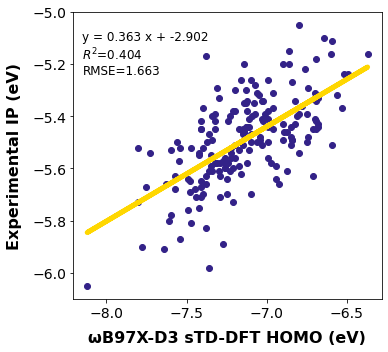

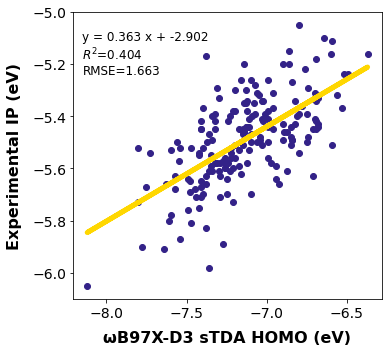

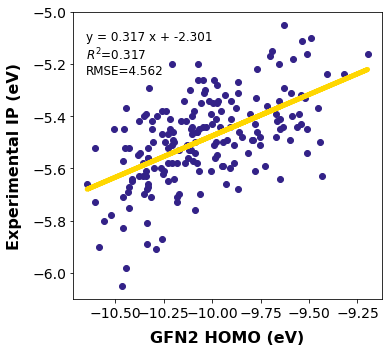

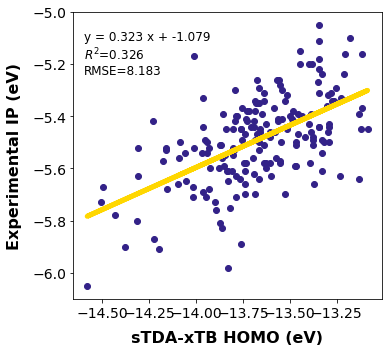

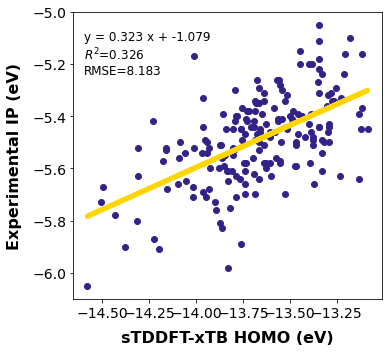

In [26]:
plot_correlation(homo_df['sTDDFT_HOMO'], homo_df['HOMO'], -8.15, -5.24, '\u03C9B97X-D3 sTD-DFT HOMO (eV)', 'Experimental IP (eV)', 'HOMO_sTDDFT_wB97X-D3')
plot_correlation(homo_df['sTDA_HOMO'], homo_df['HOMO'], -8.15, -5.24, '\u03C9B97X-D3 sTDA HOMO (eV)', 'Experimental IP (eV)', 'HOMO_sTDA_wB97X-D3')
plot_correlation(homo_df['GFN2_HOMO'], homo_df['HOMO'], -10.65, -5.24, 'GFN2 HOMO (eV)', 'Experimental IP (eV)', 'HOMO_GFN2')
plot_correlation(homo_df['sTDA-xTB_HOMO'], homo_df['HOMO'], -14.6, -5.24, 'sTDA-xTB HOMO (eV)', 'Experimental IP (eV)', 'HOMO_sTDA-xTB')
plot_correlation(homo_df['sTDDFT-xTB_HOMO'], homo_df['HOMO'], -14.6, -5.24, 'sTDDFT-xTB HOMO (eV)', 'Experimental IP (eV)', 'HOMO_sTDDFT-xTB')
#plot_correlation(homo_df['xtb_vipea_HOMO'], homo_df['HOMO'], -4.6, -6.05, 'xTB vipea HOMO (eV)', 'Experimental IP (eV)', 'HOMO_xTB_vipea')

sTDDFT and sTDA computed the exact same HOMO and LUMO energies

In [204]:
X = homo_df['sTDA_HOMO']
y = homo_df['HOMO']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions_homo_sTDA = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   HOMO   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     119.1
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           5.42e-22
Time:                        14:28:54   Log-Likelihood:                 117.51
No. Observations:                 199   AIC:                            -231.0
Df Residuals:                     197   BIC:                            -224.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1260      0.217    -14.397      0.000      -3.554      -2.698
sTDA_HOMO      0.3314      0.030     10.914      0.000       0.271       0.391
==============================================================================
Omnibus:                        1.014   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.602   Jarque-Bera (JB):                0.680
Skew:                          -0.025   Prob(JB):                        0.712
Kurtosis:                       3.282   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## LUMO predictions

In [29]:
LUMO_df = df8.filter(['LUMO', 'sTDDFT_LUMO', 'sTDA_LUMO', 'GFN2_LUMO', 'sTDA-xTB_LUMO', 'sTDDFT-xTB_LUMO'])
LUMO_df = LUMO_df.dropna()
LUMO_df

,LUMO,sTDDFT_LUMO,sTDA_LUMO,GFN2_LUMO,sTDA-xTB_LUMO,sTDDFT-xTB_LUMO
2D-PBTCl,-3.60,-1.30,-1.30,-8.5673,-8.106,-8.106
2FIFIC,-3.97,-2.23,-2.23,-9.3307,-9.186,-9.186
2T2Se-F,-3.83,-2.29,-2.29,-9.4929,-9.318,-9.318
3BDT-5,-3.40,-1.38,-1.38,-8.6746,-8.454,-8.454
4T-1,-4.09,-2.09,-2.09,-9.3832,-9.195,-9.195
...,...,...,...,...,...,...
TTIDIC,-3.92,-1.95,-1.95,-9.1965,-9.034,-9.034
UF-Qx-2F,-3.84,-2.21,-2.21,-9.2586,-9.241,-9.241
Y6-O,-3.71,-2.12,-2.12,-9.3682,-9.032,-9.032
Y9,-3.78,-2.04,-2.04,-9.2014,-9.253,-9.253


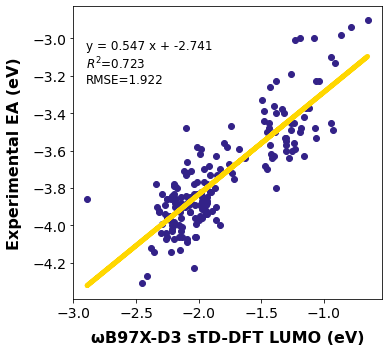

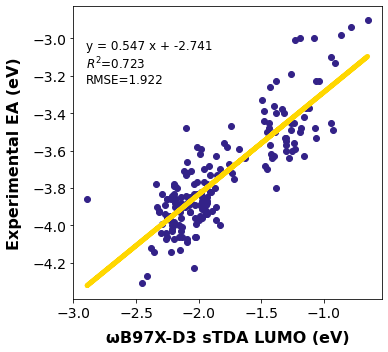

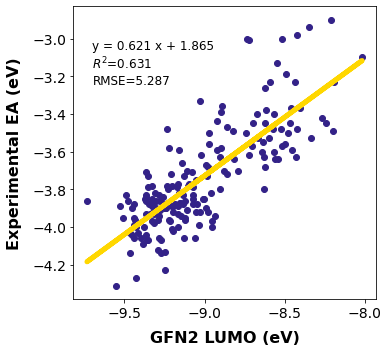

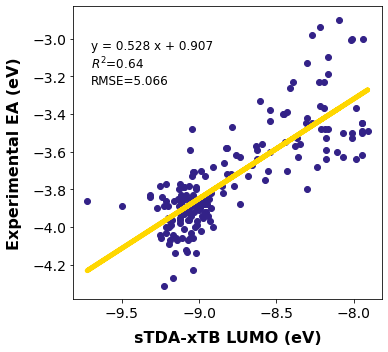

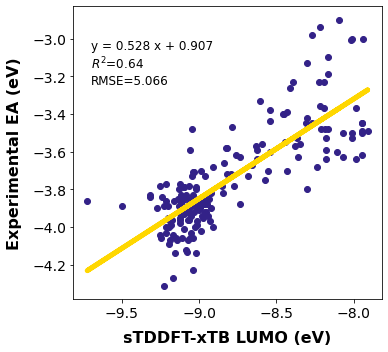

In [37]:
plot_correlation(LUMO_df['sTDDFT_LUMO'], LUMO_df['LUMO'], -2.9, -3.24, '\u03C9B97X-D3 sTD-DFT LUMO (eV)', 'Experimental EA (eV)', 'LUMO_sTDDFT_wB97X-D3')
plot_correlation(LUMO_df['sTDA_LUMO'], LUMO_df['LUMO'], -2.9, -3.24, '\u03C9B97X-D3 sTDA LUMO (eV)', 'Experimental EA (eV)', 'LUMO_sTDA_wB97X-D3')
plot_correlation(LUMO_df['GFN2_LUMO'], LUMO_df['LUMO'], -9.7, -3.24, 'GFN2 LUMO (eV)', 'Experimental EA (eV)', 'LUMO_GFN2')
plot_correlation(LUMO_df['sTDA-xTB_LUMO'], LUMO_df['LUMO'], -9.7, -3.24, 'sTDA-xTB LUMO (eV)', 'Experimental EA (eV)', 'LUMO_sTDA-xTB')
plot_correlation(LUMO_df['sTDDFT-xTB_LUMO'], LUMO_df['LUMO'], -9.7, -3.24, 'sTDDFT-xTB LUMO (eV)', 'Experimental EA (eV)', 'LUMO_sTDDFT-xTB')
#plot_correlation(LUMO_df['xtb_vipea_LUMO'], LUMO_df['LUMO'], -2, -4.26, 'xTB vipea LUMO (eV)', 'Experimental EA (eV)', 'LUMO_xTB_vipea')

## Optical Bandgap predictions

In [39]:
optbg_df = df8.filter(['optbg', 'sTDDFT_optbg', 'sTDA_optbg', 'sTDA-xTB_optbg', 'sTDDFT-xTB_optbg'])
optbg_df = optbg_df.dropna()
optbg_df

,optbg,sTDDFT_optbg,sTDA_optbg,sTDA-xTB_optbg,sTDDFT-xTB_optbg
2D-PBTCl,1.72,2.61,2.63,2.79,2.76
2FIFIC,1.38,2.20,2.25,2.46,2.39
2T2Se-F,1.31,2.20,2.22,2.37,2.32
3BDT-5,1.90,2.68,2.69,3.00,2.97
4T-1,1.47,2.44,2.47,2.51,2.46
...,...,...,...,...,...
TTIDIC,1.46,2.29,2.31,2.42,2.38
UF-Qx-2F,1.32,2.01,2.04,2.33,2.29
Y6-O,1.52,2.46,2.49,2.54,2.48
Y9,1.36,2.76,2.82,2.69,2.65


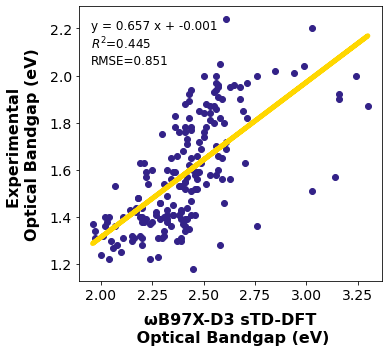

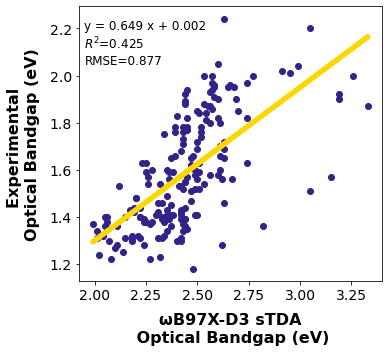

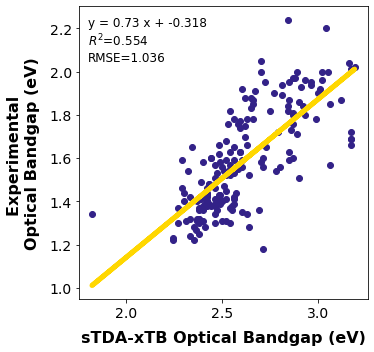

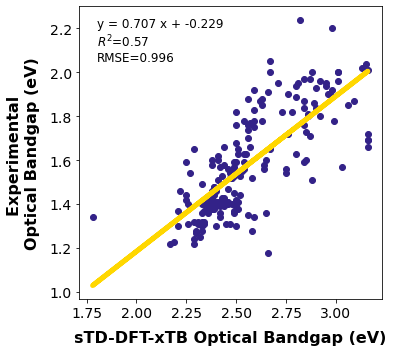

In [40]:
plot_correlation(optbg_df['sTDDFT_optbg'], optbg_df['optbg'], 1.95, 2.05, '\u03C9B97X-D3 sTD-DFT\n Optical Bandgap (eV)', 'Experimental \nOptical Bandgap (eV)', 'optbg_sTDDFT_wB97X-D3')
plot_correlation(optbg_df['sTDA_optbg'], optbg_df['optbg'],1.95, 2.05, '\u03C9B97X-D3 sTDA\n Optical Bandgap (eV)', 'Experimental \nOptical Bandgap (eV)', 'optbg_sTDA_wB97X-D3')
plot_correlation(optbg_df['sTDA-xTB_optbg'], optbg_df['optbg'], 1.8, 2.05, 'sTDA-xTB Optical Bandgap (eV)', 'Experimental \nOptical Bandgap (eV)', 'optbg_sTDA-xTB')
plot_correlation(optbg_df['sTDDFT-xTB_optbg'], optbg_df['optbg'], 1.8, 2.05, 'sTD-DFT-xTB Optical Bandgap (eV)', 'Experimental \nOptical Bandgap (eV)', 'optbg_sTDDFT-xTB')

## Maximum Absorption in Films predictions

In [41]:
abs_film_df = df8.filter(['wavelength_film', 'sTDDFT_max_abs', 'sTDA_max_abs', 'sTDA-xTB_max_abs', 'sTDDFT-xTB_max_abs'])
abs_film_df = abs_film_df.dropna()
abs_film_df

,wavelength_film,sTDDFT_max_abs,sTDA_max_abs,sTDA-xTB_max_abs,sTDDFT-xTB_max_abs
2D-PBTCl,627.0,474.1,471.1,445.0,449.8
2FIFIC,817.0,562.6,552.2,504.8,518.3
2T2Se-F,806.0,564.8,558.1,523.4,533.9
3BDT-5,584.0,463.2,460.1,413.9,417.9
4T-1,704.0,508.9,502.9,494.8,504.3
...,...,...,...,...,...
TTIDIC,766.0,540.5,536.3,512.1,520.4
UF-Qx-2F,804.0,615.3,606.6,532.0,540.7
Y6-O,768.0,504.8,498.7,488.5,498.8
Y9,808.0,448.6,438.9,412.6,425.7


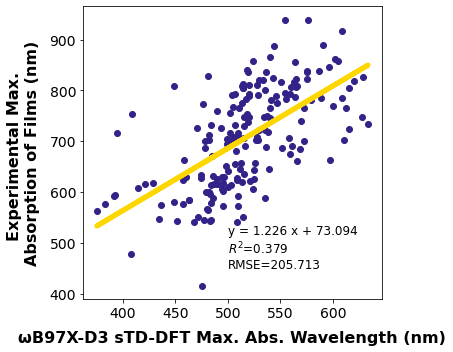

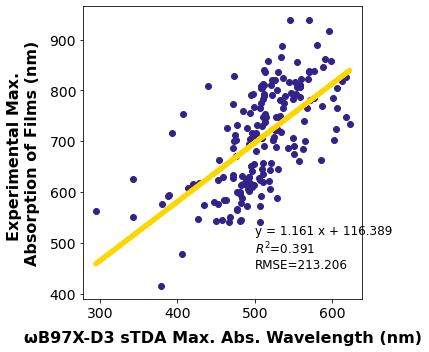

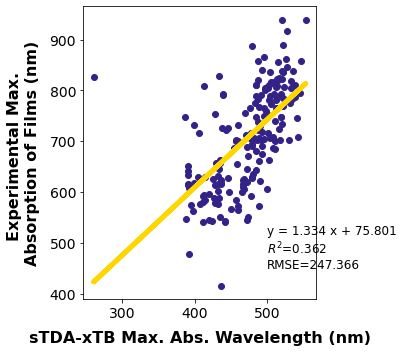

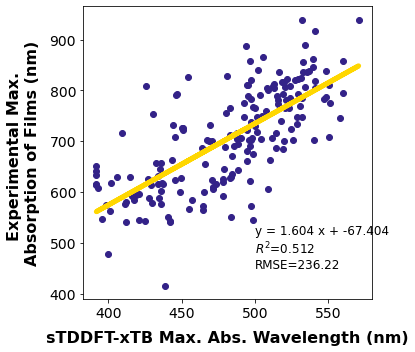

In [42]:
plot_correlation(abs_film_df['sTDDFT_max_abs'], abs_film_df['wavelength_film'], 500, 450, '\u03C9B97X-D3 sTD-DFT Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Films (nm)', 'max_abs_film_sTDDFT_wB97X-D3')
plot_correlation(abs_film_df['sTDA_max_abs'], abs_film_df['wavelength_film'], 500, 450, '\u03C9B97X-D3 sTDA Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Films (nm)', 'max_abs_film_sTDA_wB97X-D3')
plot_correlation(abs_film_df['sTDA-xTB_max_abs'], abs_film_df['wavelength_film'], 500, 450, 'sTDA-xTB Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Films (nm)', 'max_abs_film_sTDA-xTB')
plot_correlation(abs_film_df['sTDDFT-xTB_max_abs'], abs_film_df['wavelength_film'], 500, 450, 'sTDDFT-xTB Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Films (nm)', 'max_abs_film_sTDDFT-xTB')

## Maximum Absorption in Solution predictions

In [72]:
abs_soln_df = df8.filter(['wavelength_soln', 'sTDDFT_max_abs', 'sTDA_max_abs', 'sTDA-xTB_max_abs', 'sTDDFT-xTB_max_abs'])
abs_soln_df = abs_soln_df.dropna()
abs_soln_df

,wavelength_soln,sTDDFT_max_abs,sTDA_max_abs,sTDA-xTB_max_abs,sTDDFT-xTB_max_abs
2D-PBTCl,625.0,474.1,471.1,445.0,449.8
2FIFIC,750.0,562.6,552.2,504.8,518.3
2T2Se-F,694.0,564.8,558.1,523.4,533.9
3BDT-5,512.0,463.2,460.1,413.9,417.9
4T-1,600.0,508.9,502.9,494.8,504.3
...,...,...,...,...,...
TTIDIC,705.0,540.5,536.3,512.1,520.4
UF-Qx-2F,759.0,615.3,606.6,532.0,540.7
Y6-O,702.0,504.8,498.7,488.5,498.8
Y9,720.0,499.8,491.6,412.6,425.7


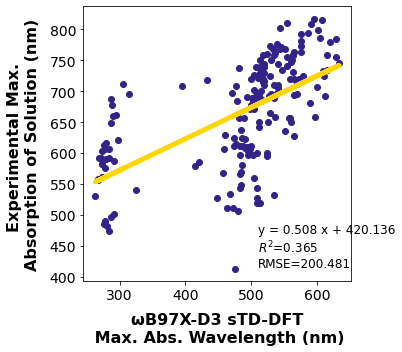

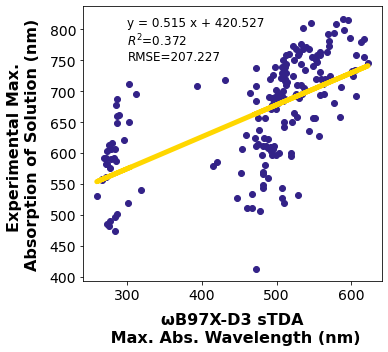

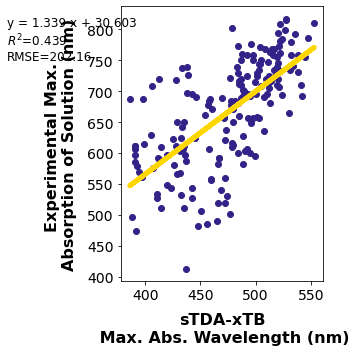

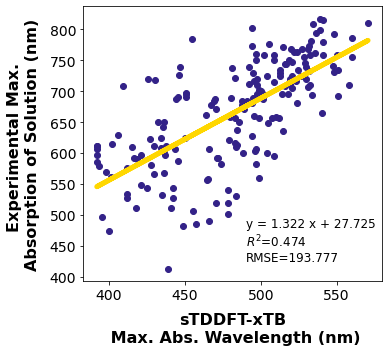

In [73]:
plot_correlation(abs_soln_df['sTDDFT_max_abs'], abs_soln_df['wavelength_soln'], 510, 415, '\u03C9B97X-D3 sTD-DFT\n Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Solution (nm)', 'max_abs_soln_sTDDFT_wB97X-D3')
plot_correlation(abs_soln_df['sTDA_max_abs'], abs_soln_df['wavelength_soln'], 300, 750, '\u03C9B97X-D3 sTDA\n Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Solution (nm)', 'max_abs_soln_sTDA_wB97X-D3')
plot_correlation(abs_soln_df['sTDA-xTB_max_abs'], abs_soln_df['wavelength_soln'], 275, 750, 'sTDA-xTB\n Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Solution (nm)', 'max_abs_soln_sTDA-xTB')
plot_correlation(abs_soln_df['sTDDFT-xTB_max_abs'], abs_soln_df['wavelength_soln'], 490, 425, 'sTDDFT-xTB\n Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Solution (nm)', 'max_abs_soln_sTDDFT-xTB')

# Compare MAPE to examine errors

In [45]:
sTDDFT_abs_soln = metrics.mean_absolute_percentage_error(abs_soln_df['wavelength_soln'], abs_soln_df['sTDDFT_max_abs'])
sTDA_abs_soln = metrics.mean_absolute_percentage_error(abs_soln_df['wavelength_soln'], abs_soln_df['sTDA_max_abs'])
sTDA_xTB_abs_soln = metrics.mean_absolute_percentage_error(abs_soln_df['wavelength_soln'], abs_soln_df['sTDA-xTB_max_abs'])
sTDDFT_xTB_abs_soln = metrics.mean_absolute_percentage_error(abs_soln_df['wavelength_soln'], abs_soln_df['sTDDFT-xTB_max_abs'])

sTDDFT_abs_film = metrics.mean_absolute_percentage_error(abs_film_df['wavelength_film'], abs_film_df['sTDDFT_max_abs'])
sTDA_abs_film = metrics.mean_absolute_percentage_error(abs_film_df['wavelength_film'], abs_film_df['sTDA_max_abs'])
sTDA_xTB_abs_film = metrics.mean_absolute_percentage_error(abs_film_df['wavelength_film'], abs_film_df['sTDA-xTB_max_abs'])
sTDDFT_xTB_abs_film = metrics.mean_absolute_percentage_error(abs_film_df['wavelength_film'], abs_film_df['sTDDFT-xTB_max_abs'])

sTDDFT_optbg = metrics.mean_absolute_percentage_error(optbg_df['optbg'], optbg_df['sTDDFT_optbg'])
sTDA_optbg = metrics.mean_absolute_percentage_error(optbg_df['optbg'], optbg_df['sTDA_optbg'])
sTDA_xTB_optbg = metrics.mean_absolute_percentage_error(optbg_df['optbg'], optbg_df['sTDA-xTB_optbg'])
sTDDFT_xTB_optbg = metrics.mean_absolute_percentage_error(optbg_df['optbg'], optbg_df['sTDDFT-xTB_optbg'])

sTDDFT_LUMO = metrics.mean_absolute_percentage_error(LUMO_df['LUMO'], LUMO_df['sTDDFT_LUMO'])
sTDA_LUMO = metrics.mean_absolute_percentage_error(LUMO_df['LUMO'], LUMO_df['sTDA_LUMO'])
sTDA_xTB_LUMO = metrics.mean_absolute_percentage_error(LUMO_df['LUMO'], LUMO_df['sTDA-xTB_LUMO'])
sTDDFT_xTB_LUMO = metrics.mean_absolute_percentage_error(LUMO_df['LUMO'], LUMO_df['sTDDFT-xTB_LUMO'])
GFN2_LUMO = metrics.mean_absolute_percentage_error(LUMO_df['LUMO'], LUMO_df['GFN2_LUMO'])

sTDDFT_HOMO = metrics.mean_absolute_percentage_error(homo_df['HOMO'], homo_df['sTDDFT_HOMO'])
sTDA_HOMO = metrics.mean_absolute_percentage_error(homo_df['HOMO'], homo_df['sTDA_HOMO'])
sTDA_xTB_HOMO = metrics.mean_absolute_percentage_error(homo_df['HOMO'], homo_df['sTDA-xTB_HOMO'])
sTDDFT_xTB_HOMO = metrics.mean_absolute_percentage_error(homo_df['HOMO'], homo_df['sTDDFT-xTB_HOMO'])
GFN2_HOMO = metrics.mean_absolute_percentage_error(homo_df['HOMO'], homo_df['GFN2_HOMO'])

labels = ['HOMO', 'LUMO', 'Optical Bandgap', 'Max. Abs. Solution']


#plot_correlation(abs_soln_df['sTDDFT_max_abs'], abs_soln_df['wavelength_soln'], 975, 450, '\u03C9B97X-D3 sTD-DFT Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Solution (nm)', 'max_abs_soln_sTDDFT_wB97X-D3')
#plot_correlation(abs_soln_df['sTDA_max_abs'], abs_soln_df['wavelength_soln'], 700, 450, '\u03C9B97X-D3 sTDA Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Solution (nm)', 'max_abs_soln_sTDA_wB97X-D3')
#plot_correlation(abs_soln_df['sTDA-xTB_max_abs'], abs_soln_df['wavelength_soln'], 600, 450, 'sTDA-xTB Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Solution (nm)', 'max_abs_soln_sTDA-xTB')
#plot_correlation(abs_soln_df['sTDDFT-xTB_max_abs'], abs_soln_df['wavelength_soln'], 600, 450, 'sTDDFT-xTB Max. Abs. Wavelength (nm)', 'Experimental Max. \nAbsorption of Solution (nm)', 'max_abs_soln_sTDDFT-xTB')

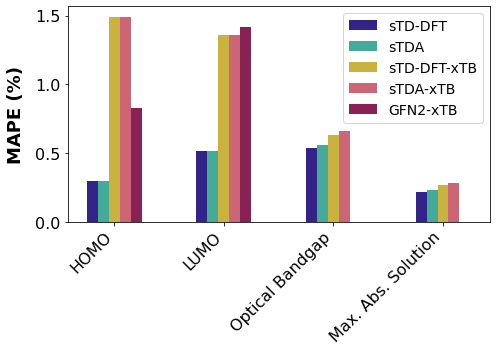

In [46]:
fig, ax = plt.subplots(figsize = (7, 5))

x = np.arange(4)
sTDDFT = [sTDDFT_HOMO, sTDDFT_LUMO, sTDDFT_optbg, sTDDFT_abs_soln]
sTDA = [sTDA_HOMO, sTDA_LUMO, sTDA_optbg, sTDA_abs_soln]
sTDDFT_xTB = [sTDA_xTB_HOMO, sTDDFT_xTB_LUMO,  sTDDFT_xTB_optbg, sTDDFT_xTB_abs_soln]
sTDA_xTB = [sTDA_xTB_HOMO, sTDA_xTB_LUMO, sTDA_xTB_optbg, sTDA_xTB_abs_soln]
GFN2 = [GFN2_HOMO, GFN2_LUMO, 0, 0]

width = 0.1

  
# plot data in grouped manner of bar type
ax.bar(x-0.2, sTDDFT, width, color='#332288')
ax.bar(x-0.1, sTDA, width, color='#44AA99')
ax.bar(x, sTDDFT_xTB, width, color='#CAB23F')
ax.bar(x+0.1, sTDA_xTB, width, color='#CC6677')
ax.bar(x+0.2, GFN2, width, color='#882255')

plt.xticks(x, labels)

ax.set_ylabel('MAPE (%)', labelpad=10, weight='bold', size=18)
ax.tick_params(axis = 'x', labelsize=16, rotation=45)
ax.set_xticklabels(labels, ha='right')
ax.tick_params(axis = 'y', labelsize=16)

y_ticks = [0, 0.5, 1, 1.5]
plt.yticks(y_ticks)

plt.legend(["sTD-DFT", 'sTDA', 'sTD-DFT-xTB', 'sTDA-xTB', 'GFN2-xTB'], fontsize=14)

plt.tight_layout()

plt.savefig('MAPE_barchart.pdf', dpi=600)
plt.savefig('MAPE_barchart.png', dpi=600)
plt.show()